In [1]:
import os, yaml
import numpy as np
from scipy.interpolate import CubicSpline

mass = [700, 800, 1000, 1200, 1400, 1800, 2000, 2200, 2400, 3000, 3500]
excluded_mass = [900, 1600, 2600]
all_mass = [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
from matplotlib.ticker import MultipleLocator
from cycler import cycler
from matplotlib.cm import get_cmap
mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)


def interpolate_plot(mass, parameters, plot_name: str, y_name: str, x_name=r'$m(Z^\prime)$ [GeV]', year='Run2', x_min=650, x_max=3800, excluded_mass=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))

    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(1, 1)
    ax = f.add_subplot(gs[0])
    ax.grid()
    hep.cms.label(data=False, ax=ax, fontsize=18, year=year, lumi=round(LUMI[year], 1))


    x = np.arange(x_min, x_max+1, 10)
    param = [parameters[m] for m in mass]
    cs = CubicSpline(mass, param)
    ax.plot(x, cs(x), color='#ff7f0e', label='interpolation', linewidth=2)
    ax.errorbar(mass, param, yerr=np.sqrt(param), label='simulated sample', linestyle='', fmt='o', markersize=8, linewidth=2, color='#1f77b4')
    if excluded_mass is not None:
        excluded_param = [parameters[m] for m in excluded_mass]
        ax.errorbar(excluded_mass, excluded_param, yerr=np.sqrt(excluded_param), label='excluded simulation', linestyle='', fmt='o', markersize=8, linewidth=2, color='#d62728')
    

    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(ax.get_ylim()[0]*0.9, ax.get_ylim()[1]*1.2)
    ax.xaxis.set_minor_locator(MultipleLocator(100))
    ax.tick_params(axis='both', which='major', width=1, length=10, labelsize=16, direction='in')
    ax.tick_params(axis='both', which='minor', width=1, length=5, labelsize=16, direction='in')
    ax.set_ylabel(y_name, fontsize=20, ha='right', y=0.95, rotation=0)
    ax.set_xlabel(x_name, fontsize=20, ha='right', x=1)
    ax.ticklabel_format(useOffset=False, style='plain')

    ax.legend(loc="best", ncol=1, frameon=False, fontsize=16)

    if not os.path.exists(f'./plots/{year}'):
        os.makedirs(f'./plots/{year}')
    prefix = 'exclude_' if excluded_mass is not None else ''
    plt.savefig(f"./plots/{year}/{prefix}{plot_name}.pdf", bbox_inches='tight')
    plt.show()

/tmp/ipykernel_1949468/2764225220.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)


In [3]:
def double_sided_cyrstall_ball(x, x0, sigmaL, sigmaR, alphaL, nL, alphaR, nR):
    AL = np.power(nL/np.abs(alphaL), nL) * np.exp(-alphaL**2/2)
    AR = np.power(nR/np.abs(alphaR), nR) * np.exp(-alphaR**2/2)
    BL = nL/np.abs(alphaL) - np.abs(alphaL)
    BR = nR/np.abs(alphaR) - np.abs(alphaR)
    if x - x0 < -alphaL*sigmaL:
        return AL*(BL-(x-x0)/sigmaL)**(-nL)
    elif x - x0 <= 0:
        return np.exp(-((x-x0)/sigmaL)**2/2)
    elif x - x0 <= alphaR*sigmaR:
        return np.exp(-((x-x0)/sigmaR)**2/2)
    else:
        return AR*(BR+(x-x0)/sigmaR)**(-nR)
    
def DCB(x, x0, sigmaL, sigmaR, alphaL, nL, alphaR, nR, event_sum):
    return event_sum * np.array([double_sided_cyrstall_ball(i, x0, sigmaL, sigmaR, alphaL, nL, alphaR, nR) for i in x])
    

# Parameter interpolation

In [8]:
param_dir = 'workspace/Run2/'
stats = {'SRZ1': {}, 'SRZ2': {}}
#all_mass = range(700, 3001, 50)
for m in all_mass:
    f = os.path.join('fit' if 'fit' not in os.getcwd() else '', param_dir, str(m)+'_10p0', 'signal_SRZ1.yaml')
    with open(f, 'r') as file:
        parameters = yaml.safe_load(file)
    for k, v in parameters.items():
        if k not in stats['SRZ1']:
            stats['SRZ1'][k] = {}
        stats['SRZ1'][k][m] = v
    
    f = os.path.join('fit' if 'fit' not in os.getcwd() else '', param_dir, str(m)+'_10p0', 'signal_SRZ1.yaml')
    with open(f, 'r') as file:
        parameters = yaml.safe_load(file)
    for k, v in parameters.items():
        if k not in stats['SRZ2']:
            stats['SRZ2'][k] = {}
        stats['SRZ2'][k][m] = v

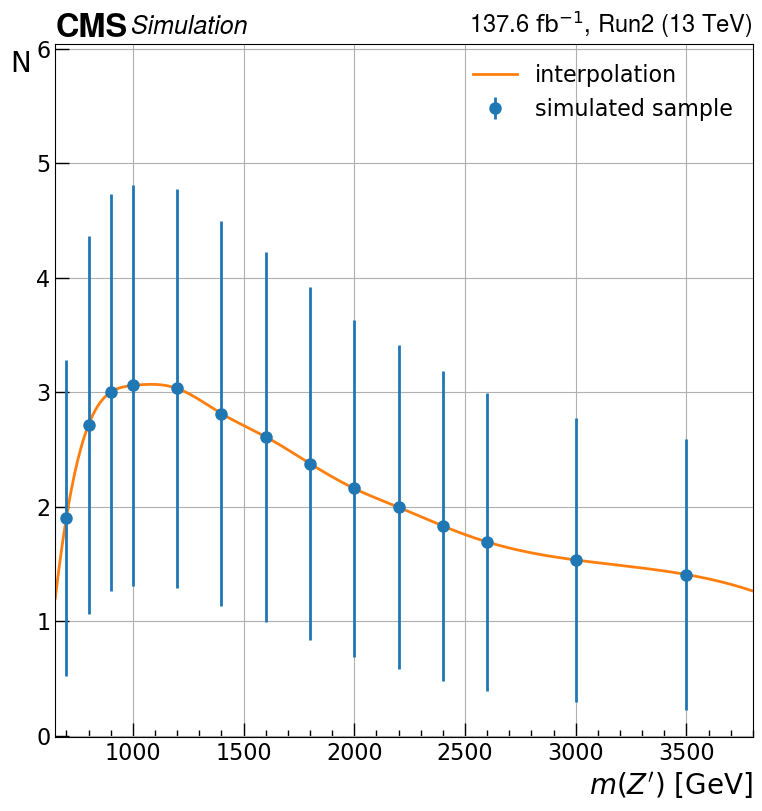

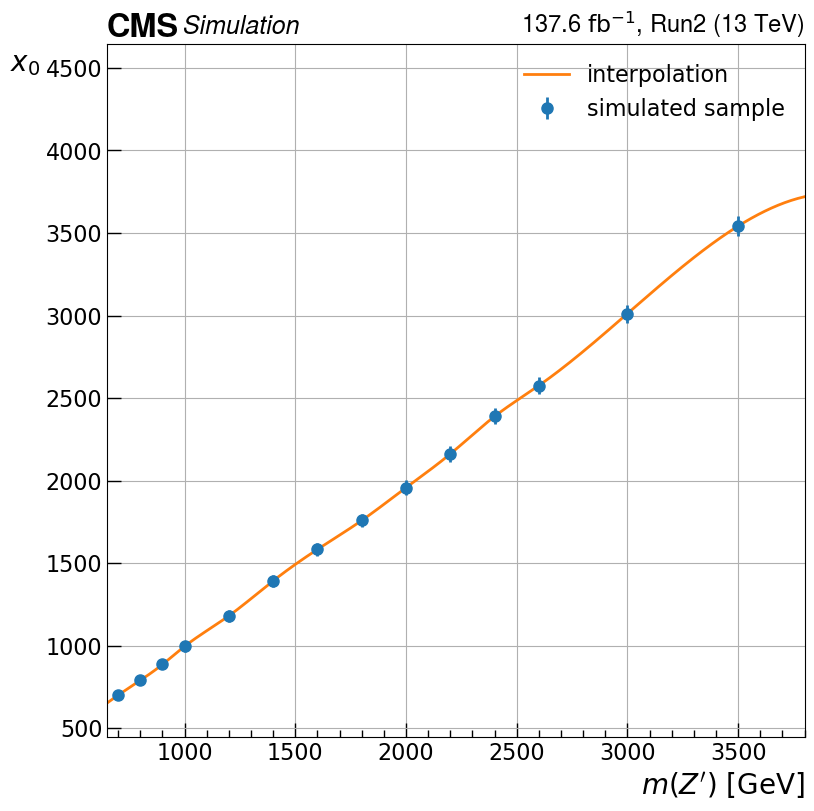

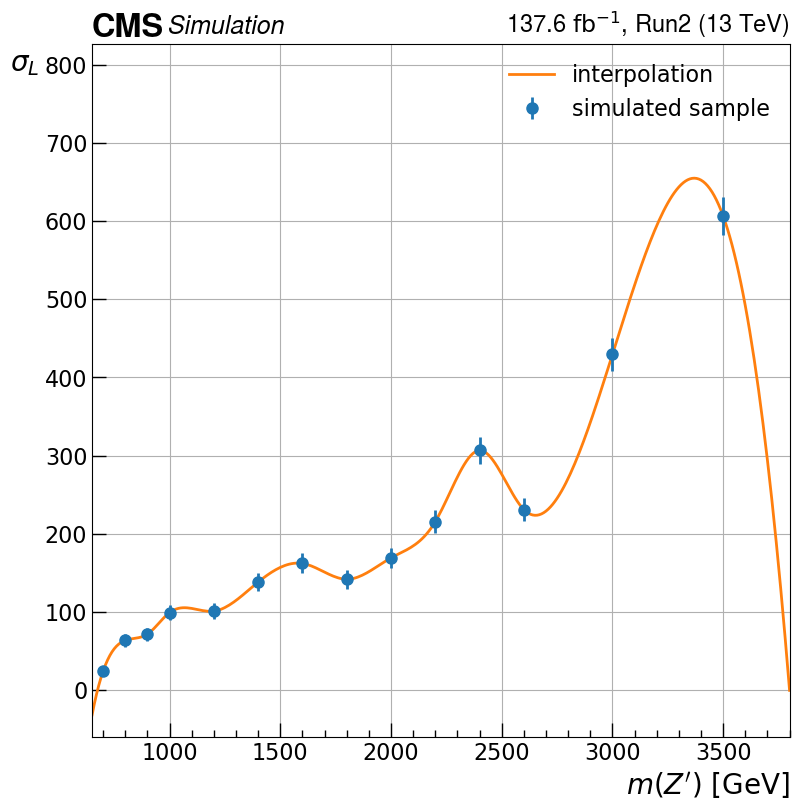

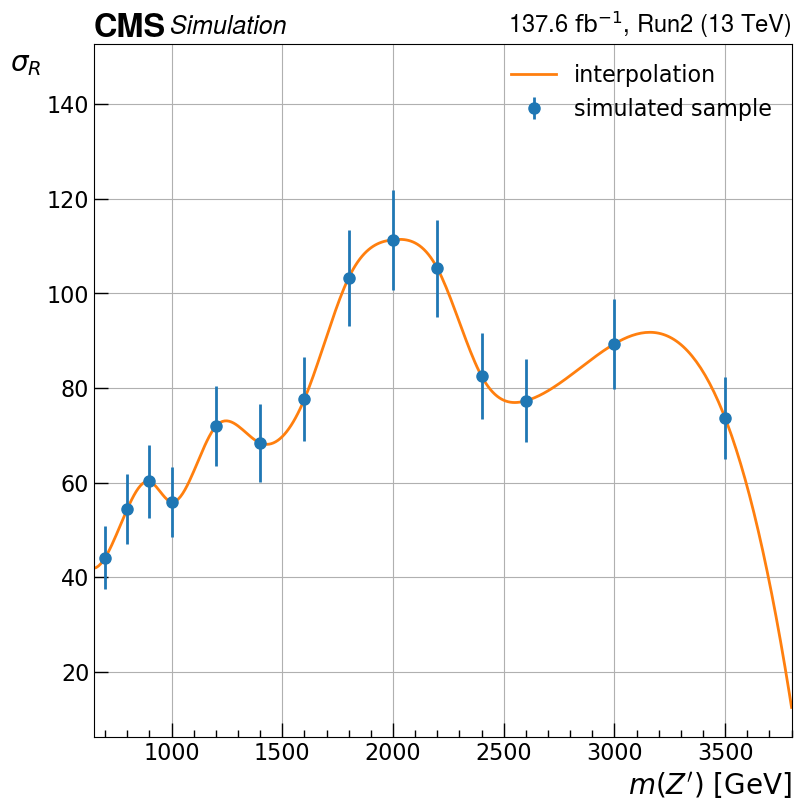

In [9]:
for SR in ['SRZ2']:
    interpolate_plot(all_mass, parameters=stats[SR]['event_sum'], plot_name=f'interpolate_{SR}_N', y_name='N')
    interpolate_plot(all_mass, parameters=stats[SR]['x0'], plot_name=f'interpolate_{SR}_x0', y_name=r'$x_0$')
    interpolate_plot(all_mass, parameters=stats[SR]['sigmaL'], plot_name=f'interpolate_{SR}_sigmaL', y_name=r'$\sigma_L$')
    interpolate_plot(all_mass, parameters=stats[SR]['sigmaR'], plot_name=f'interpolate_{SR}_sigmaR', y_name=r'$\sigma_R$')
    #interpolate_plot(all_mass, parameters=stats[SR]['nL'], plot_name=f'interpolate_{SR}_nL', y_name=r'$n_L$')
    #interpolate_plot(all_mass, parameters=stats[SR]['nR'], plot_name=f'interpolate_{SR}_nR', y_name=r'$n_R$')
    #interpolate_plot(all_mass, parameters=stats[SR]['alphaL'], plot_name=f'interpolate_{SR}_alphaL', y_name=r'$\alpha_L$')
    #interpolate_plot(all_mass, parameters=stats[SR]['alphaR'], plot_name=f'interpolate_{SR}_alphaR', y_name=r'$\alpha_R$')

## Exclude simulation test

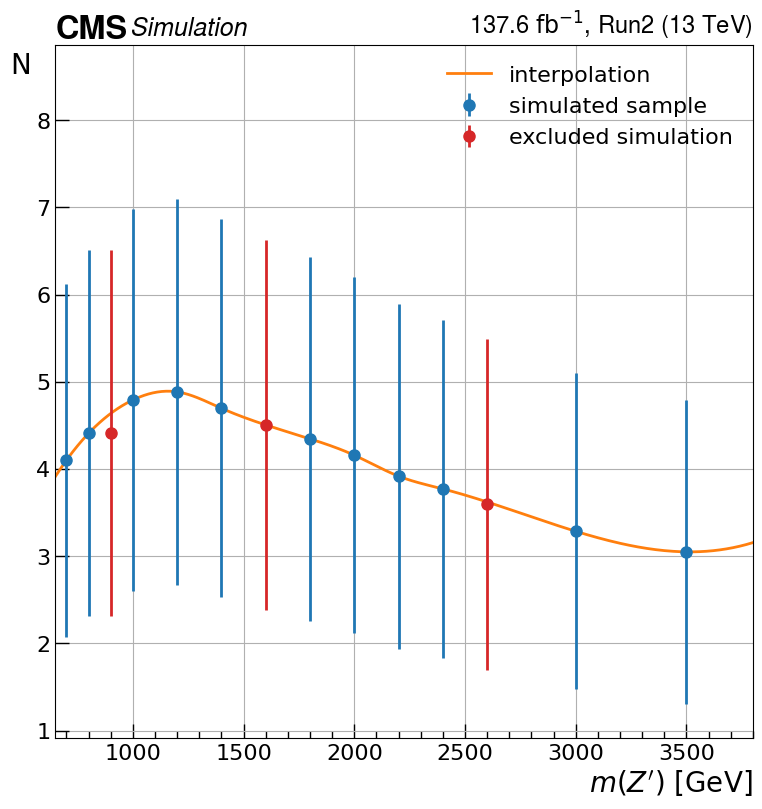

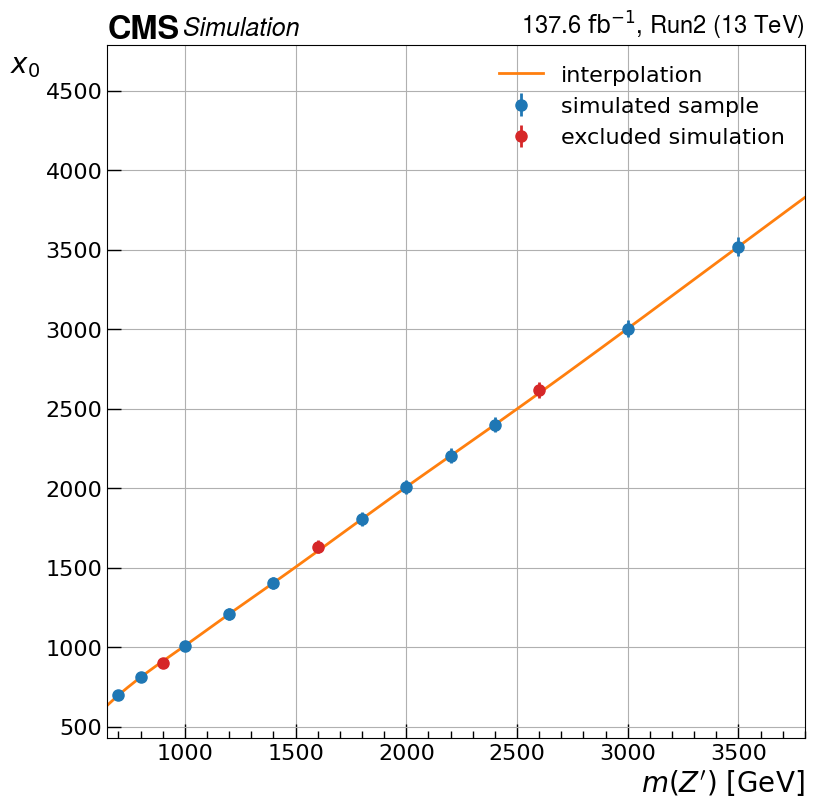

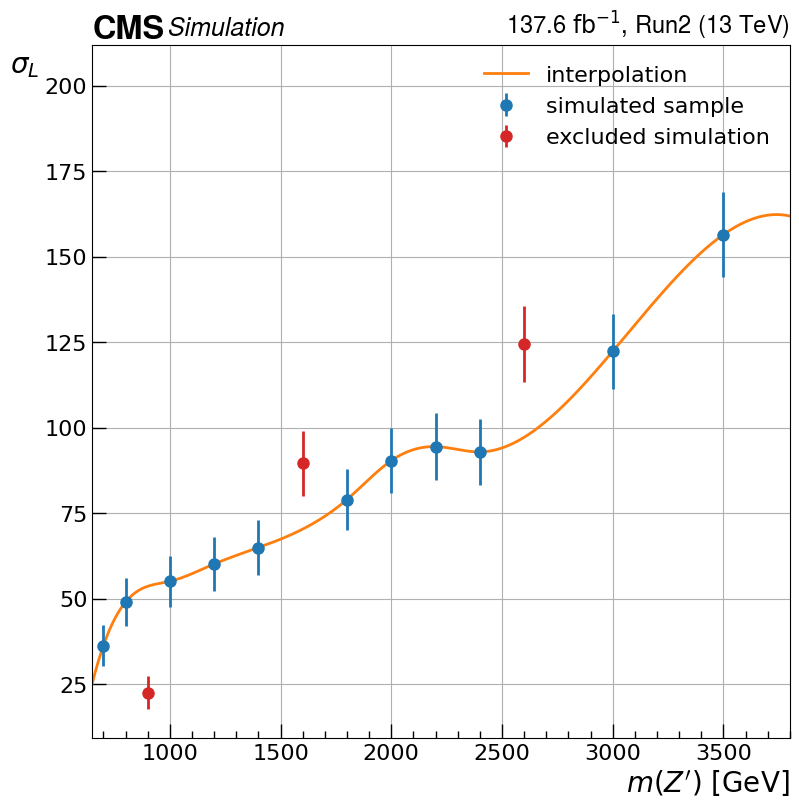

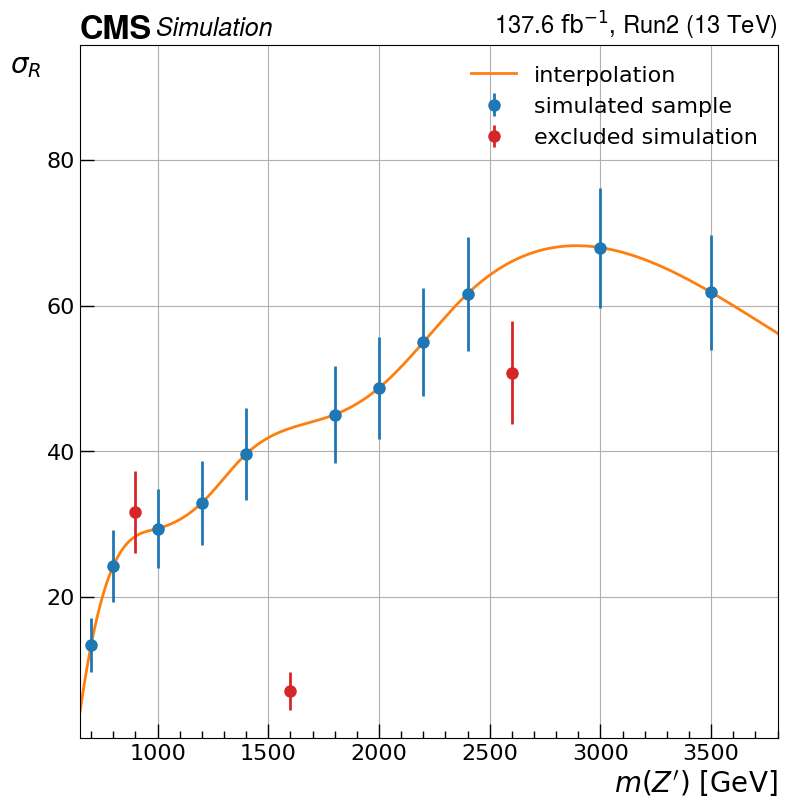

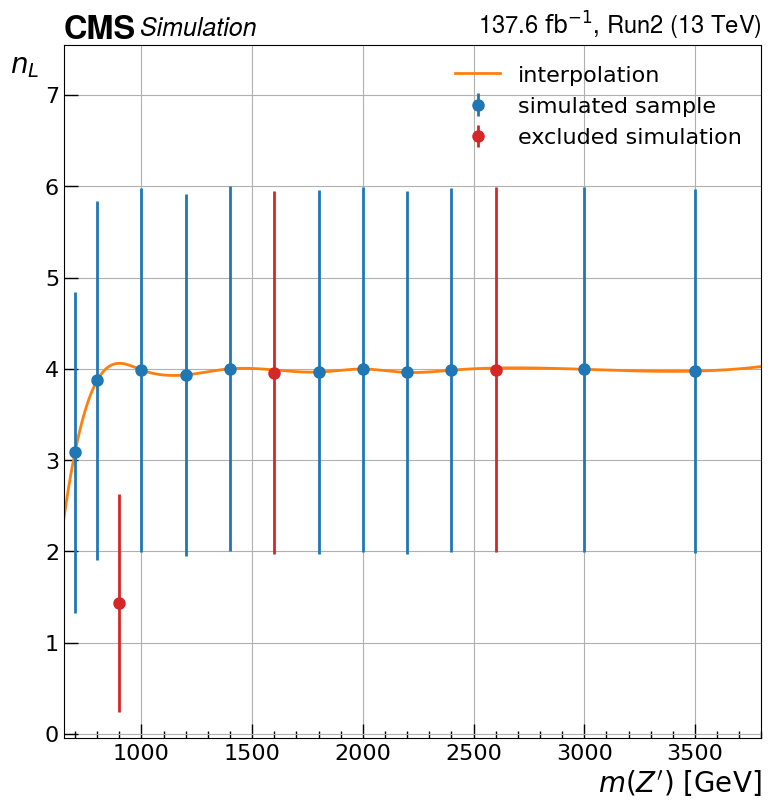

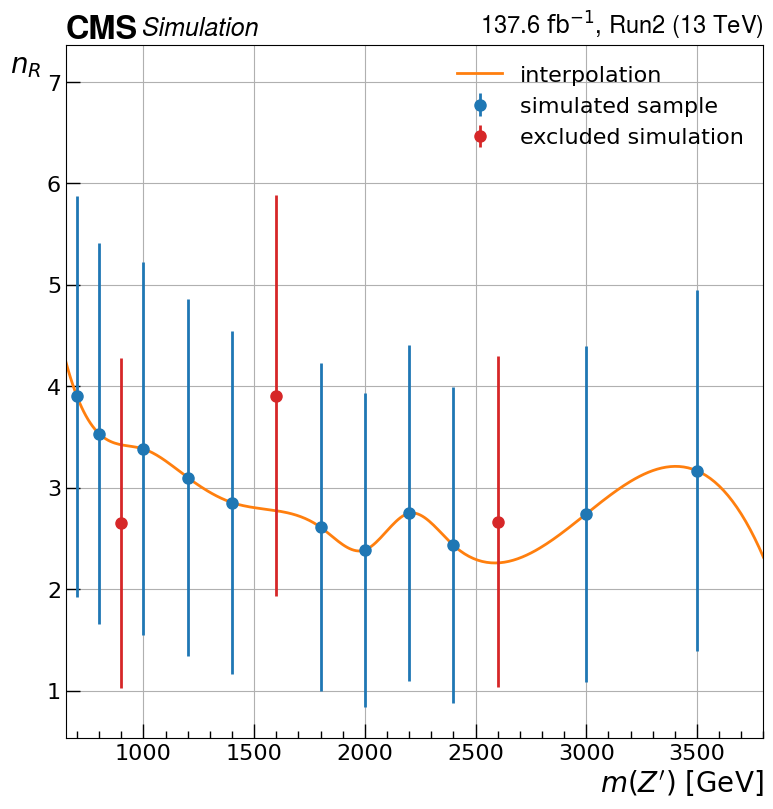

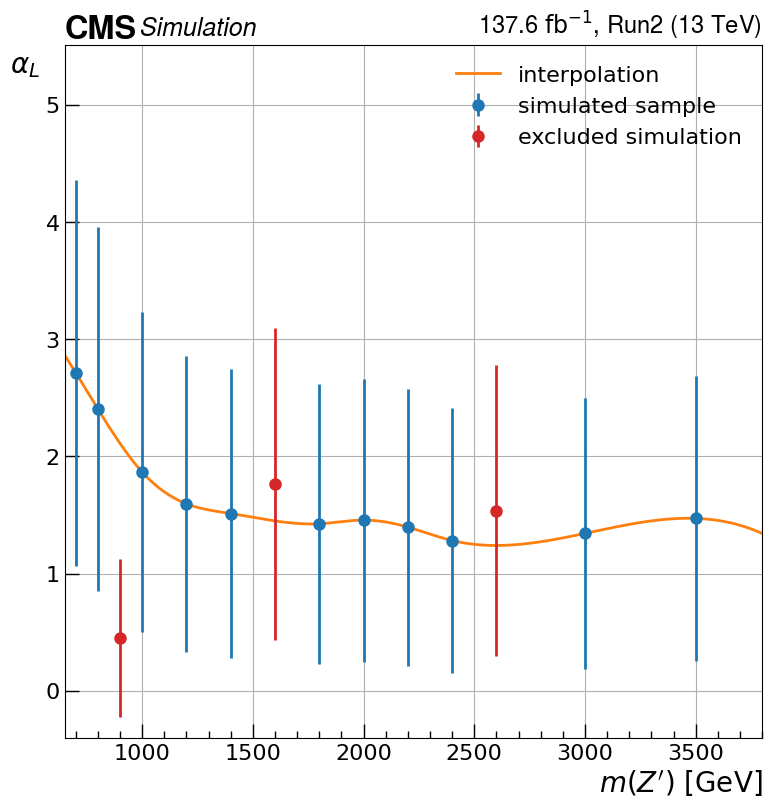

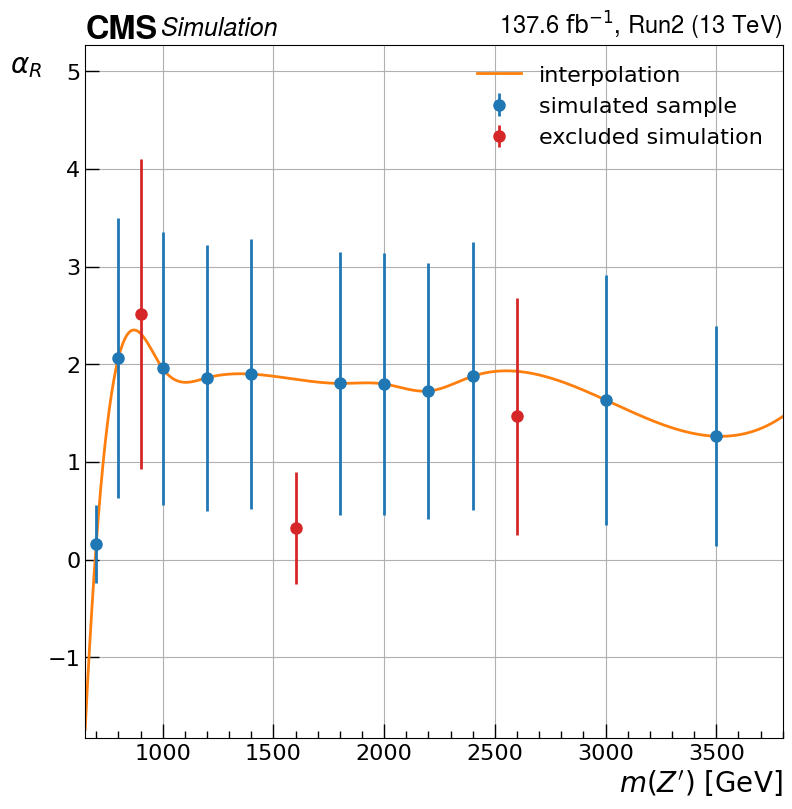

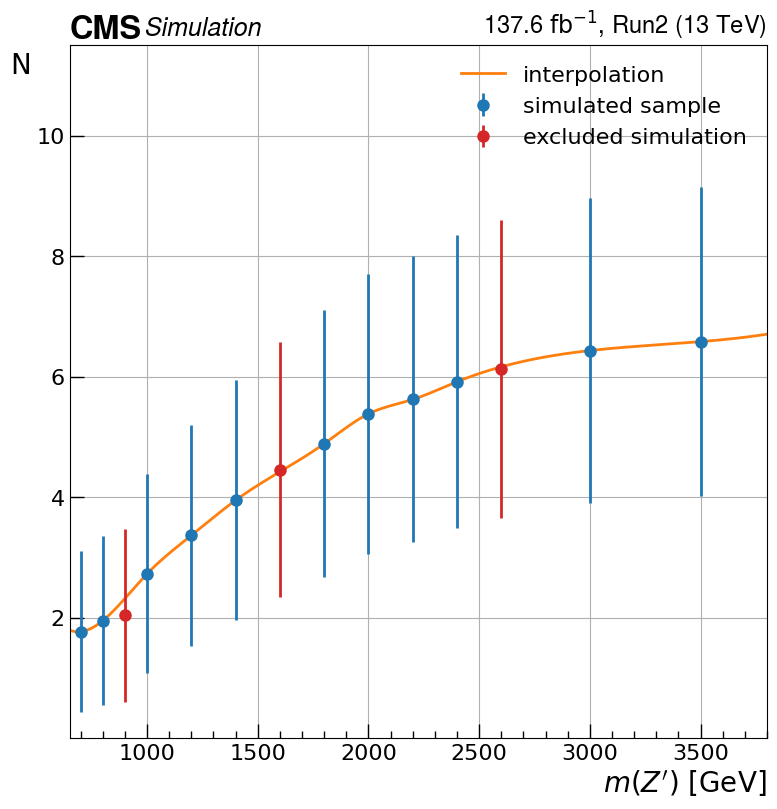

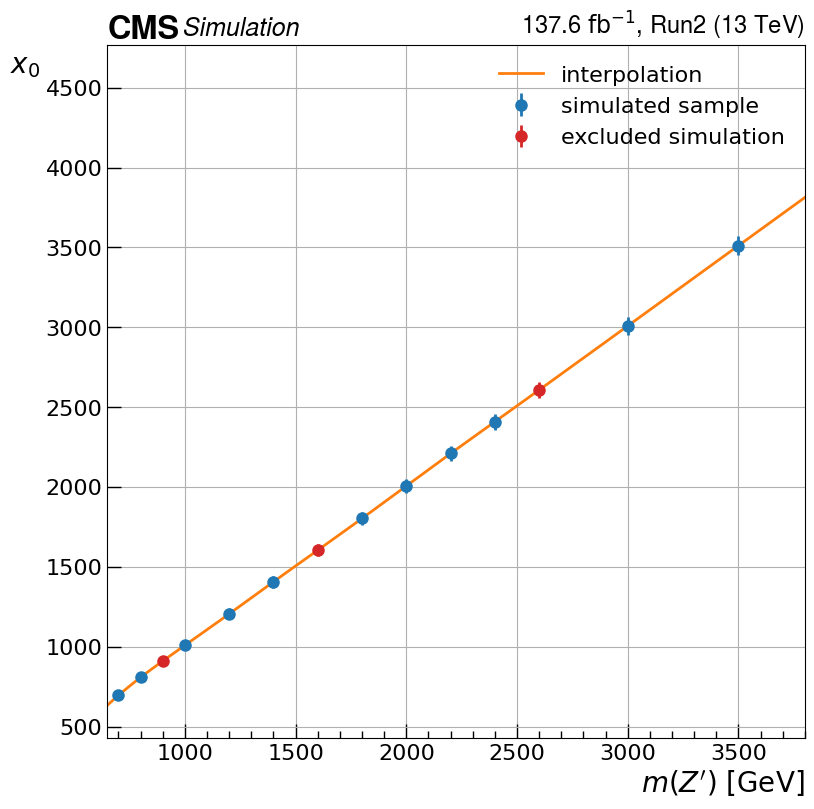

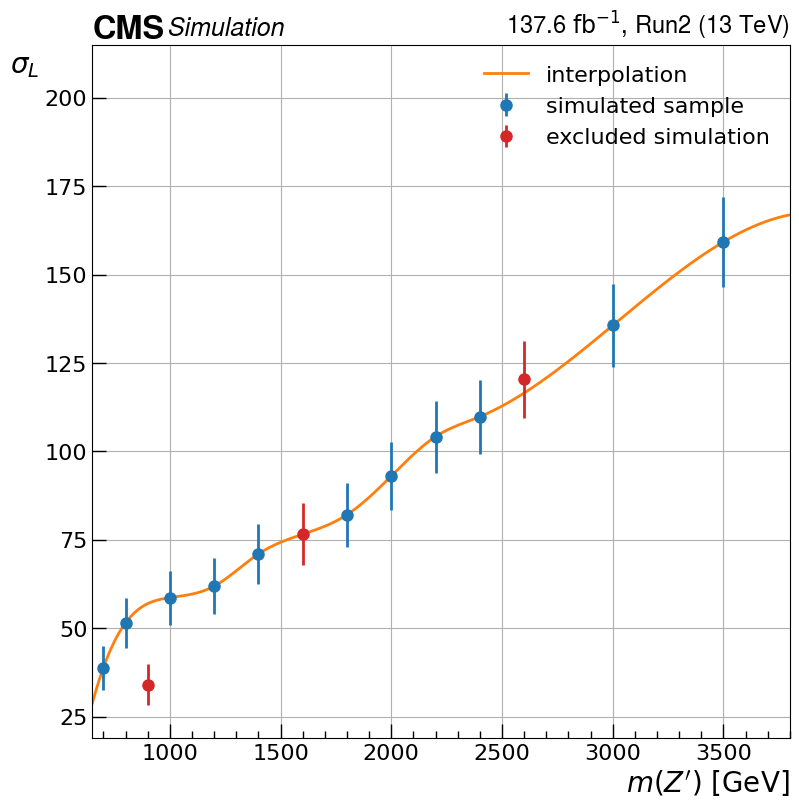

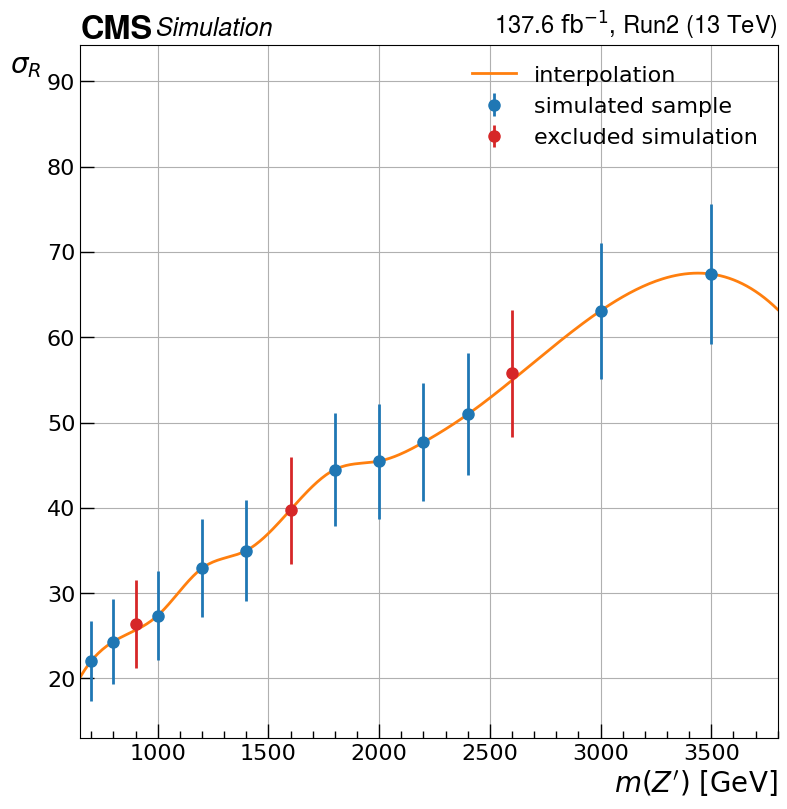

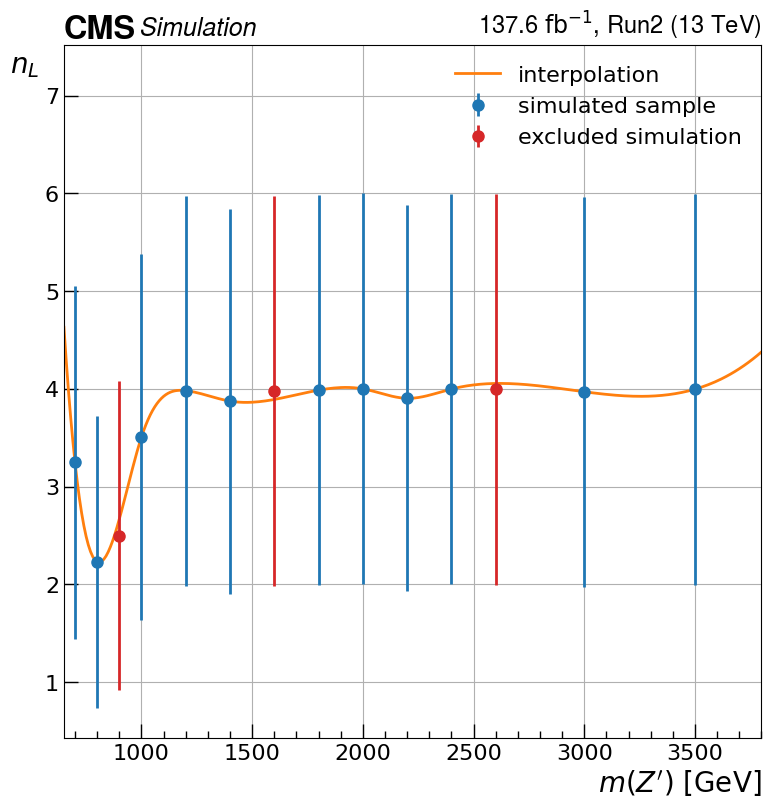

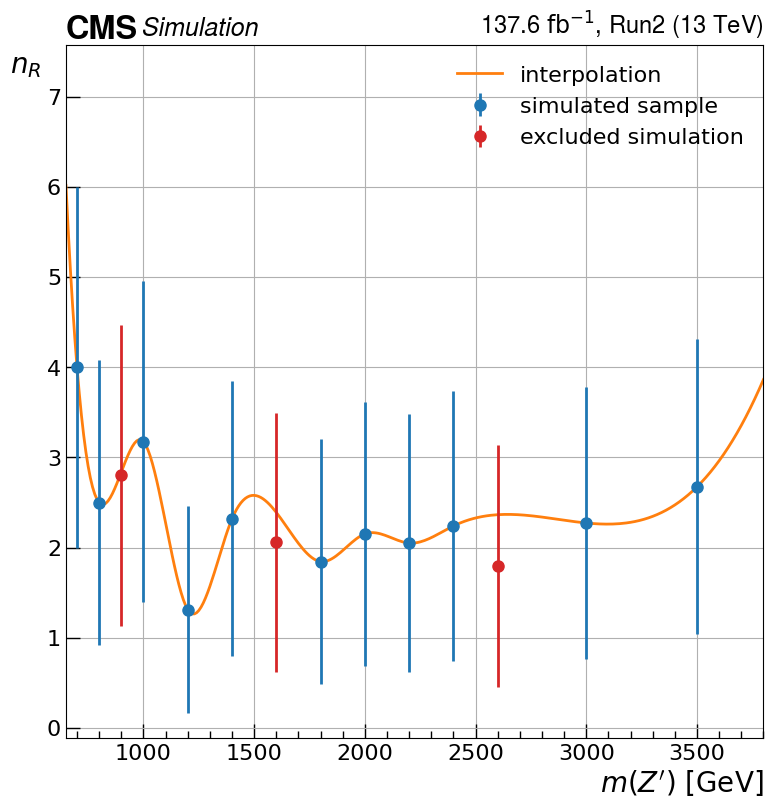

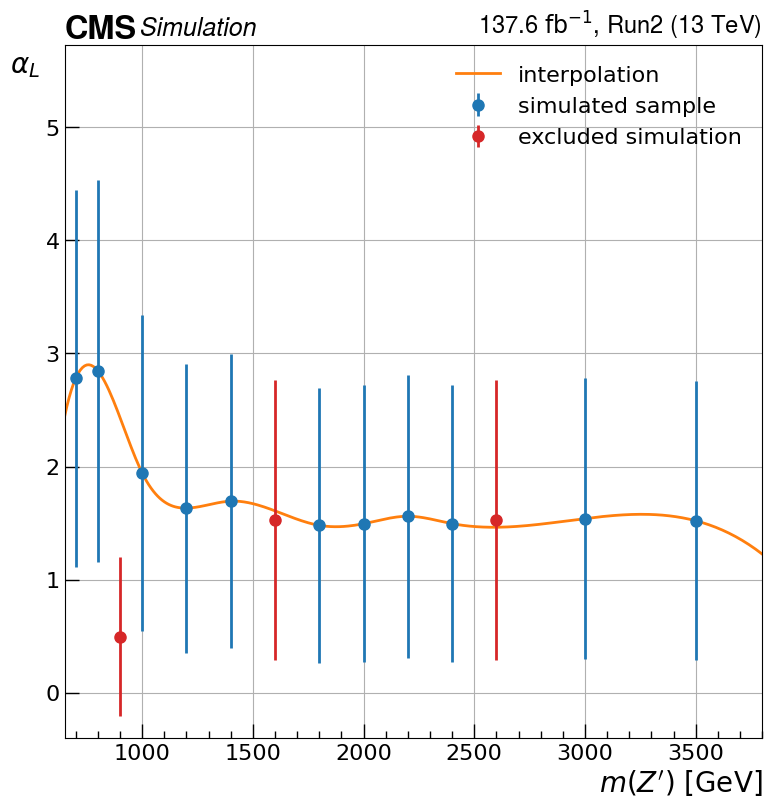

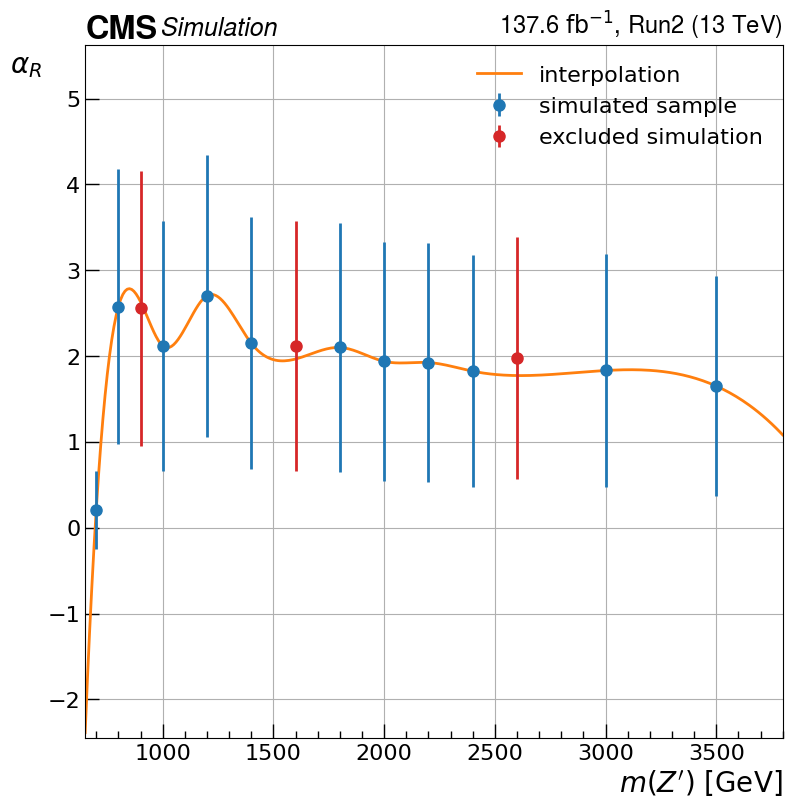

In [6]:
for SR in ['SR1', 'SR2']:
    interpolate_plot(mass, parameters=stats[SR]['event_sum'], plot_name=f'interpolate_{SR}_N', y_name='N', excluded_mass=excluded_mass)
    interpolate_plot(mass, parameters=stats[SR]['x0'], plot_name=f'interpolate_{SR}_x0', y_name=r'$x_0$', excluded_mass=excluded_mass)
    interpolate_plot(mass, parameters=stats[SR]['sigmaL'], plot_name=f'interpolate_{SR}_sigmaL', y_name=r'$\sigma_L$', excluded_mass=excluded_mass)
    interpolate_plot(mass, parameters=stats[SR]['sigmaR'], plot_name=f'interpolate_{SR}_sigmaR', y_name=r'$\sigma_R$', excluded_mass=excluded_mass)
    interpolate_plot(mass, parameters=stats[SR]['nL'], plot_name=f'interpolate_{SR}_nL', y_name=r'$n_L$', excluded_mass=excluded_mass)
    interpolate_plot(mass, parameters=stats[SR]['nR'], plot_name=f'interpolate_{SR}_nR', y_name=r'$n_R$', excluded_mass=excluded_mass)
    interpolate_plot(mass, parameters=stats[SR]['alphaL'], plot_name=f'interpolate_{SR}_alphaL', y_name=r'$\alpha_L$', excluded_mass=excluded_mass)
    interpolate_plot(mass, parameters=stats[SR]['alphaR'], plot_name=f'interpolate_{SR}_alphaR', y_name=r'$\alpha_R$', excluded_mass=excluded_mass)


In [ ]:
for SR in ['SRZ2']:
    #interpolate_plot(all_mass, parameters=stats[SR]['event_sum'], plot_name=f'interpolate_{SR}_N', y_name='N')
    #interpolate_plot(all_mass, parameters=stats[SR]['x0'], plot_name=f'interpolate_{SR}_x0', y_name=r'$x_0$')
    #interpolate_plot(all_mass, parameters=stats[SR]['sigmaL'], plot_name=f'interpolate_{SR}_sigmaL', y_name=r'$\sigma_L$')
    #interpolate_plot(all_mass, parameters=stats[SR]['sigmaR'], plot_name=f'interpolate_{SR}_sigmaR', y_name=r'$\sigma_R$')
    interpolate_plot(all_mass, parameters=stats[SR]['nL'], plot_name=f'interpolate_{SR}_nL', y_name=r'$n_L$')
    interpolate_plot(all_mass, parameters=stats[SR]['nR'], plot_name=f'interpolate_{SR}_nR', y_name=r'$n_R$')
    interpolate_plot(all_mass, parameters=stats[SR]['alphaL'], plot_name=f'interpolate_{SR}_alphaL', y_name=r'$\alpha_L$')
    interpolate_plot(all_mass, parameters=stats[SR]['alphaR'], plot_name=f'interpolate_{SR}_alphaR', y_name=r'$\alpha_R$')

# Interpolate Signal

In [9]:
SIG_COLOR = {
    r'1000$\to H(bb)\gamma$': 'red',
    r'1000$\to Z(bb)\gamma$': 'blue',
    r'1000_5p6$\to Z(bb)\gamma$': 'cyan',
    r'1000_10p0$\to Z(bb)\gamma$': 'gold',
}

def interpolate_signal(mass, stats, SR, y_name='A.U.', x_name=r'$m_{resonace}$ [GeV]', year='Run2', x_min=650, x_max=3800, excluded_mass=[]):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))

    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(1, 1)
    ax = f.add_subplot(gs[0])
    ax.grid()
    hep.cms.label(data=False, ax=ax, fontsize=18, year=year, lumi=round(LUMI[year], 1))


    cs = {}
    for i in range(700, x_max+1, 50):
        for p in ['x0', 'nL', 'nR', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'event_sum']:
            cs[p] = CubicSpline(mass, [stats[SR][p][m] for m in mass])

        x = np.arange(0.6*i, 1.4*i, 2)
        if i in mass:
            if i==mass[0]:
                ax.plot(x, DCB(x, **{p: cs[p](i) for p in cs}), color='#1f77b4', linewidth=2, label='Simulated samples')
            else:
                ax.plot(x, DCB(x, **{p: cs[p](i) for p in cs}), color='#1f77b4', linewidth=2)
        elif i not in mass:
            if i==850:
                ax.plot(x, DCB(x, **{p: cs[p](i) for p in cs}), color='#ff7f0e', linewidth=2, label='Interpolated shapes')
            else:
                ax.plot(x, DCB(x, **{p: cs[p](i) for p in cs}), color='#ff7f0e', linewidth=2)
        #if i in excluded_mass:
        #    if i==excluded_mass[0]:
        #        ax.plot(x, DCB(x, **{p: stats[SR][p][i] for p in cs}), color='#d62728', linewidth=2, label='Excluded simulation')
        #    else:
        #        ax.plot(x, DCB(x, **{p: stats[SR][p][i] for p in cs}), color='#d62728', linewidth=2)
        


    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, ax.get_ylim()[1]*1.2)
    ax.xaxis.set_minor_locator(MultipleLocator(100))
    ax.tick_params(axis='both', which='major', width=1, length=10, labelsize=16, direction='in')
    ax.tick_params(axis='both', which='minor', width=1, length=5, labelsize=16, direction='in')
    ax.set_ylabel(y_name, fontsize=20, ha='right', y=0.95, rotation=0)
    ax.set_xlabel(x_name, fontsize=20, ha='right', x=1)
    ax.ticklabel_format(useOffset=False, style='plain')

    ax.legend(loc="best", ncol=1, frameon=False, fontsize=16)

    if not os.path.exists(f'./plots/fit/{year}'):
        os.makedirs(f'./plots/fit/{year}')
    prefix = 'exclude_' if excluded_mass is not None else ''
    plt.savefig(f"./plots/fit/{year}/{prefix}interpolate_{SR}.pdf", bbox_inches='tight')
    plt.show()

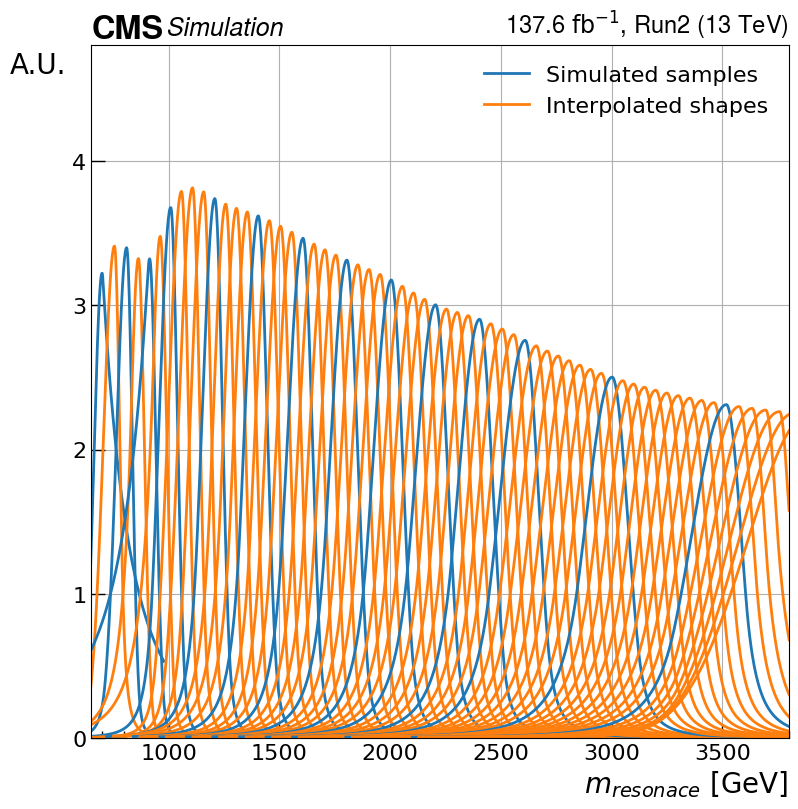

/tmp/dfu/ipykernel_2046814/3812928598.py:3: RuntimeWarning: invalid value encountered in power
  AR = np.power(nR/np.abs(alphaR), nR) * np.exp(-alphaR**2/2)
/tmp/dfu/ipykernel_2046814/3812928598.py:13: RuntimeWarning: invalid value encountered in scalar power
  return AR*(BR+(x-x0)/sigmaR)**(-nR)


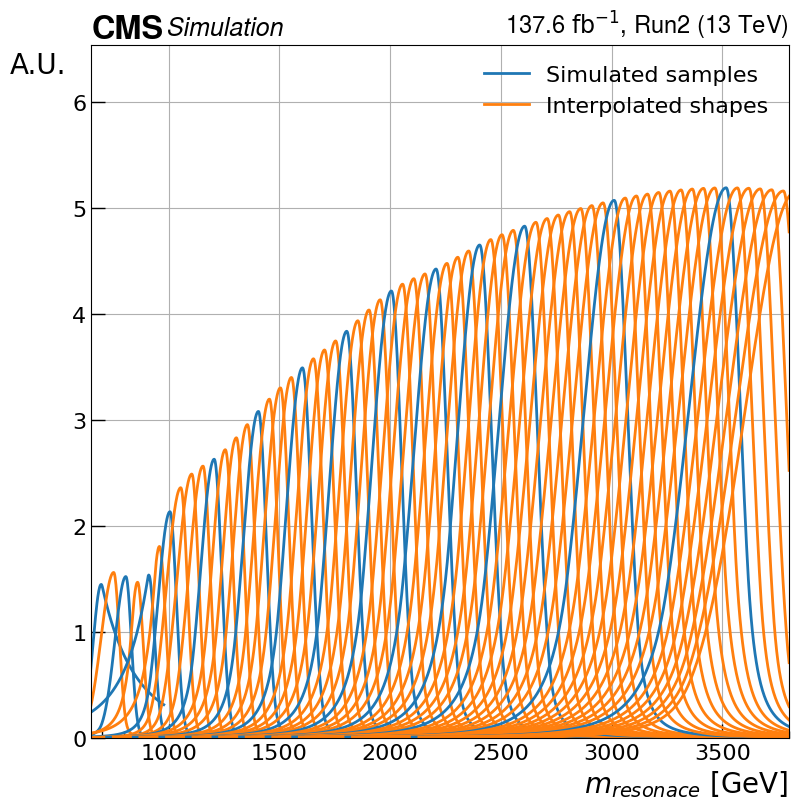

In [10]:
interpolate_signal(all_mass, stats, SR='SRZ1')
interpolate_signal(all_mass, stats, SR='SRZ2')

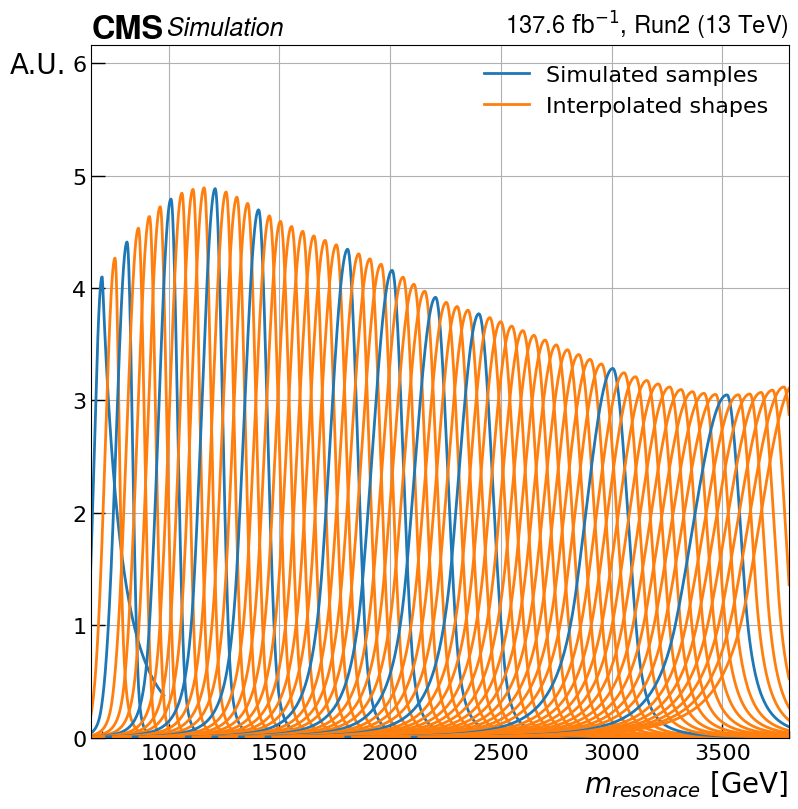

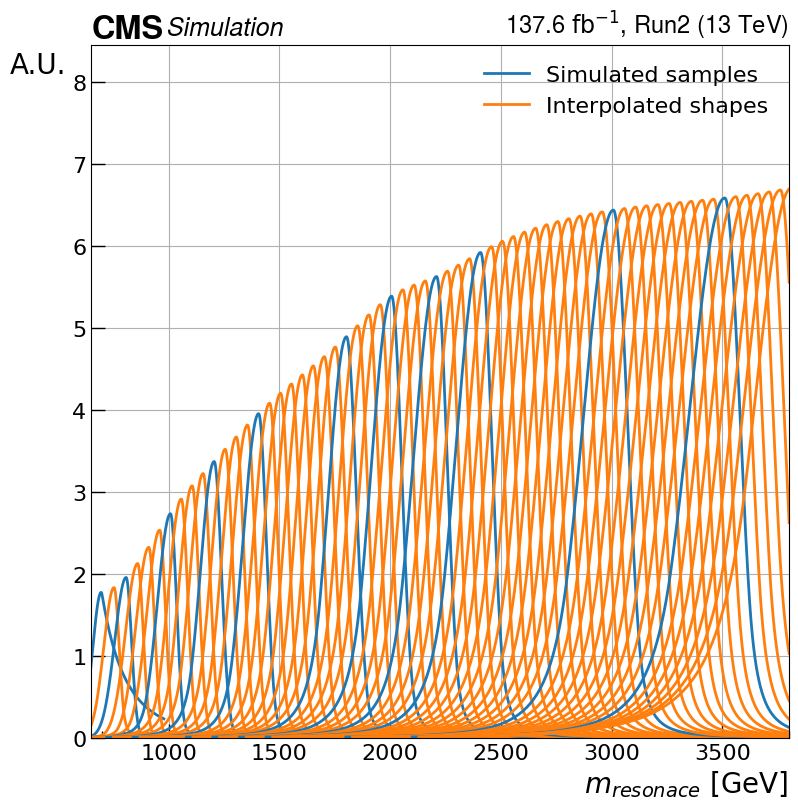

In [9]:
interpolate_signal(mass, stats, SR='SR1', excluded_mass=excluded_mass)
interpolate_signal(mass, stats, SR='SR2', excluded_mass=excluded_mass)

KeyError: 'SR1'

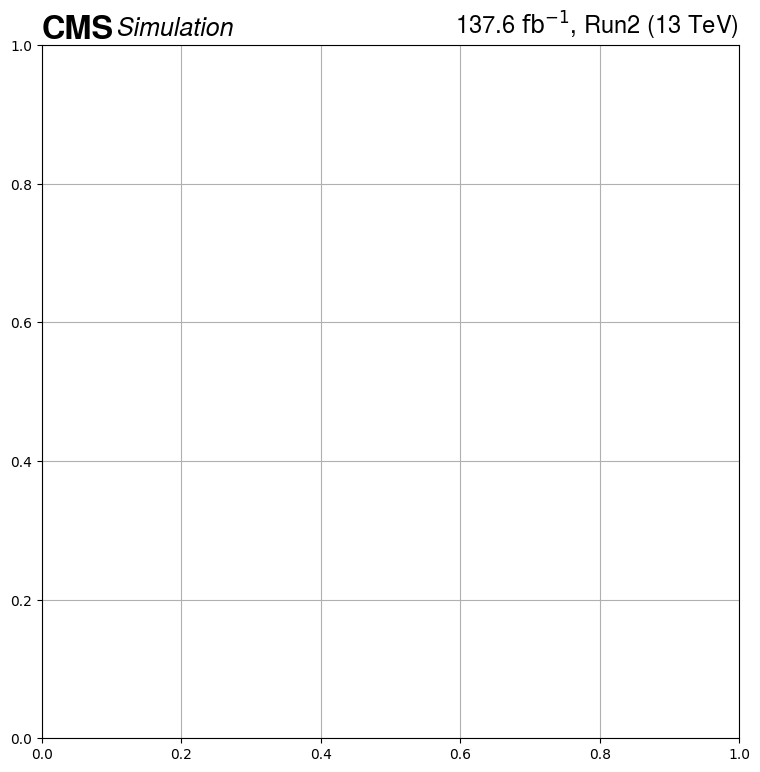

In [13]:
param_dir = './workspace/Run2/'
stats = {}
for m in [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]:
    f = os.path.join(param_dir, str(m), 'fit_info_Zbb_SR1.yaml')
    with open(f, 'r') as file:
        stats[f'{m}_SR1'] = yaml.safe_load(file)
    
    f = os.path.join(param_dir, str(m), 'fit_info_Zbb_SR2.yaml')
    with open(f, 'r') as file:
        stats[f'{m}_SR2'] = yaml.safe_load(file)

interpolate_signal(mass, stats, SR='SR1', plot_name='Zbb')
cs=interpolate_signal(mass, stats, SR='SR2', plot_name='Zbb')

In [12]:
param_dir = 'fit/workspace/Run2/'
stats = {}
for m in [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]:
    f = os.path.join(param_dir, f'{m}_5p6', 'fit_info_Zbb_SR1.yaml')
    with open(f, 'r') as file:
        stats[f'{m}_SR1'] = yaml.safe_load(file)
    
    f = os.path.join(param_dir, f'{m}_5p6', 'fit_info_Zbb_SR2.yaml')
    with open(f, 'r') as file:
        stats[f'{m}_SR2'] = yaml.safe_load(file)

interpolate_signal(mass, stats, SR='SR1', color='cyan', plot_name='Zbb_5p6')
interpolate_signal(mass, stats, SR='SR2', color='cyan', plot_name='Zbb_5p6')

FileNotFoundError: [Errno 2] No such file or directory: 'fit/workspace/Run2/700_5p6/fit_info_Zbb_SR1.yaml'